In [1]:
from utilities import prepare_data
from utilities import check_arrays_survival
from compute_survival_function import predict_survival_function  
from flc_data_preprocess import flc_preprocess
from support_data_preprocess import support_preprocess
from compas_data_preprocess import compas_preprocess
from seer_data_preprocess import seer_preprocess

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from performance_measures import c_index, brier_score, weighted_c_index, weighted_brier_score,log_partial_lik
from neural_models import negLogLikelihood, linearCoxPH_Regression, MLP, negLogLikelihood_per_sample
from fairness_measures import *

from sksurv.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import brier_score_loss
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.metrics import concordance_index_ipcw,cumulative_dynamic_auc
from sksurv.util import Surv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import argparse
from scipy import optimize
import datetime

#The function below ensures that we seed all random generators with the same value to get reproducible results
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

def threshplus(x):
    y = x.copy()
    y[y<0]=0
    return y

def threshplus_tensor(x):
    y = x.clone()
    y[y<0]=0
    return y

def loss_map_chi_factory(loss_values, eps):
    # return lambda x: np.sqrt(2)*(1.0/eps-1.0)*np.sqrt(np.mean(threshplus(loss_values-x)**2.0)) + x
    return lambda x: np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(loss_values - x) ** 2.0)) + x

def loss_map_chi_factory_tensor(loss_values, eps, opt_eta):
    # return np.sqrt(2)*(1.0/eps-1.0)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta
    return np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta

In [2]:
def fit_dro_cox(X, event, time, eps=0.1, lr=0.01, epochs=500):
    """Fit DRO-Cox model, return a nn.module instance"""
    X = Variable((torch.from_numpy(X)).float())
    event = Variable((torch.from_numpy(event)).float()) 

    criterion_per_sample = negLogLikelihood_per_sample()
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, event)

        # Update eta with beta fixed
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

        # Update beta with eta fixed
        loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, cutpt

def time_dependent_C_index(event_train, time_train, event_test, time_test, test_prediction):
    survival_train = np.dtype([('event', event_train.dtype), ('surv_time', time_train.dtype)])
    survival_train = np.empty(len(event_train), dtype=survival_train)
    survival_train['event'] = event_train
    survival_train['surv_time'] = time_train

    survival_test = np.dtype([('event', event_test.dtype), ('surv_time', time_test.dtype)])
    survival_test = np.empty(len(event_test), dtype=survival_test)
    survival_test['event'] = event_test
    survival_test['surv_time'] = time_test

    # event_times = np.arange(np.min(time_test), np.max(time_test) / 2, 75)
    event_times = np.percentile(time_test, np.linspace(5, 81, 15))
    # event_times = np.percentile(data_y['futime'], np.linspace(5, 81, 15))

    test_auc, test_mean_auc = cumulative_dynamic_auc(survival_train, survival_test, test_prediction, event_times)
    return test_mean_auc

# Experiment

In [54]:
set_random_seed(1)

#Survival Data
data_x, data_y, protect_attr = flc_preprocess()

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"])
# data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])
#
data_X_train, data_event_train, data_time_train = check_arrays_survival(data_X_train, data_y_train)
data_X_train, data_event_train, data_time_train, S_train = prepare_data(data_X_train, data_event_train, data_time_train, S_train)

data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)
#
intersectionalGroups = np.unique(S_train,axis=0) # all intersecting groups, i.e. black-women, white-man etc 
# data normalization: mean subtraction method to compute euclidean distance
scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)
data_X_test_for_distance = data_X_test / np.linalg.norm(data_X_test, axis=1, keepdims=1)

## Hyperparameter tunning

In [110]:
set_random_seed(57529)

#Survival Data
data_x, data_y, protect_attr = flc_preprocess()

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"])
# data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])
#
data_X_train, data_event_train, data_time_train = check_arrays_survival(data_X_train, data_y_train)
data_X_train, data_event_train, data_time_train, S_train = prepare_data(data_X_train, data_event_train, data_time_train, S_train)

data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)
#
intersectionalGroups = np.unique(S_train,axis=0) # all intersecting groups, i.e. black-women, white-man etc 
# data normalization: mean subtraction method to compute euclidean distance
scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)
data_X_test_for_distance = data_X_test / np.linalg.norm(data_X_test, axis=1, keepdims=1)

In [ ]:
B = 10
epochs = 500
protect_index = 0
with_scale = True
eps_candidates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
beta_fitted = np.zeros((B, data_X_train.shape[1]))
eta_fitted = np.zeros(B)
eps_tunned = np.zeros(B)
test_accuracy = np.zeros((B, 2))
test_fairness = np.zeros((B, 3))

set_random_seed(1234)
for i in range(B):
    print(f"Batch {i+1}:")
    # Train-validation split
    data_X_train_tmp, data_X_val, data_event_train_tmp, data_event_val, data_time_train_tmp, data_time_val, S_train_tmp, S_val = train_test_split(data_X_train, 
                                                                                                                                                  data_event_train, 
                                                                                                                                                  data_time_train, 
                                                                                                                                                  S_train, 
                                                                                                                                                  test_size=0.2,stratify=data_event_train)
    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp = prepare_data(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp)
    data_X_val, data_event_val, data_time_val, S_val = prepare_data(data_X_val, data_event_val, data_time_val, S_val)

    # Select best model
    base_model, _ = fit_dro_cox(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, eps=1.0, epochs=epochs)
    with torch.no_grad():
        base_val_prediction = base_model((torch.from_numpy(data_X_val)).float())
        base_val_prediction = (base_val_prediction.numpy()).reshape((-1,)) # beta \dot x
    base_acc = concordance_index_censored(data_event_val, data_time_val, base_val_prediction)[0]
    base_fair = group_fairness(base_val_prediction, S_val[:, protect_index])
    best_acc = base_acc
    best_fair = base_fair
    best_model = base_model
    best_eps = 1.0
    for eps in eps_candidates:
        model_val, eta_val = fit_dro_cox(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, eps=eps, epochs=epochs)
        with torch.no_grad():
            base_prediction = model_val((torch.from_numpy(data_X_train_tmp)).float())
            base_prediction = (base_prediction.numpy()).reshape((-1,)) # beta \dot x
        # linear predictor for test/dev data
        with torch.no_grad():
            model_prediction = model_val((torch.from_numpy(data_X_val)).float())
            model_prediction = (model_prediction.numpy()).reshape((-1,)) # beta \dot x
        #val_acc = concordance_index_censored(data_event_val, data_time_val, model_prediction)[0]
        val_acc = time_dependent_C_index(data_event_train_tmp, data_time_train_tmp, data_event_val, data_time_val, model_prediction)
        val_fair = group_fairness(model_prediction, S_val[:, protect_index])
        print("{:.2f}, {:.6f}, {:.6f}".format(eps, val_acc, val_fair))
        if (val_acc >= base_acc*0.95) & (val_fair <= best_fair):
            best_acc = val_acc
            best_fair = val_fair
            best_eps = eps
            best_model = model_val
    
    # Store best model
    eps_tunned[i] = best_eps
    beta_fitted[i,:] = next(best_model.parameters()).detach().numpy().reshape((-1,))
    print(f"Best eps: {best_eps}")

    # Evaluation on test set
    with torch.no_grad():
        train_prediction = best_model((torch.from_numpy(data_X_train)).float())
        train_prediction = (train_prediction.numpy()).reshape((-1,)) # beta \dot x

        test_prediction = best_model((torch.from_numpy(data_X_test)).float())
        test_prediction = (test_prediction.numpy()).reshape((-1,)) # beta \dot x

        # Concordance index
        # test_accuracy[i,0] = concordance_index_censored(data_event_test, data_time_test, test_prediction)[0]
        test_accuracy[i,0] = time_dependent_C_index(data_event_train, data_time_train, data_event_test, data_time_test, test_prediction)

        # Integrated Brier Score
        data_event_train = data_event_train.astype(bool)
        survFunction_test = predict_survival_function(train_prediction, data_event_train, data_time_train, test_prediction)

        percentiles = [100]
        tmp_IBS_from_sksurv = np.zeros(len(percentiles))
        min_time = 0
        if data_time_train.min()>data_time_test.min():
            min_time = data_time_train.min()
        else:
            min_time = data_time_test.min()
        t = 0
        times_range = np.linspace(min_time, np.percentile(data_time_test, percentiles[t]), num=50, endpoint=False)
        preds_ibs = np.asarray([[fn(i_t) for i_t in times_range] for fn in survFunction_test])
        tmp_IBS_from_sksurv[t] = integrated_brier_score(data_y_train, data_y_test, preds_ibs, times_range)
        test_accuracy[i,1] = tmp_IBS_from_sksurv[t]
        
        # Concordance imparity
        test_fairness[i,0] = CI(test_prediction, data_event_test, data_time_test, S_test[:, protect_index])

        # Individual fairness
        test_fairness[i,1] = individual_fairness_scale(test_prediction, data_X_test_for_distance, 0.01)

        # Group fairness
        test_fairness[i,2] = group_fairness(test_prediction, S_test[:, protect_index])

Batch 1:
0.10, 0.815849, 0.006737
0.15, 0.818731, 0.015583
0.20, 0.819420, 0.039469
0.30, 0.819083, 0.162030
0.40, 0.816994, 0.665058
0.50, 0.816027, 2.160883
Best eps: 0.1
Batch 2:
0.10, 0.804944, 0.008464
0.15, 0.809678, 0.017284
0.20, 0.811189, 0.038923
0.30, 0.812624, 0.151281
0.40, 0.813273, 0.603628
0.50, 0.812919, 1.857719
Best eps: 0.1
Batch 3:
0.10, 0.787819, 0.005325
0.15, 0.790810, 0.017003
0.20, 0.796214, 0.042238
0.30, 0.801564, 0.156343
0.40, 0.801683, 0.614378
0.50, 0.801355, 1.896799
Best eps: 0.1
Batch 4:
0.10, 0.810000, 0.008093
0.15, 0.809630, 0.018761
0.20, 0.812473, 0.041697
0.30, 0.813679, 0.147969
0.40, 0.812120, 0.582565
0.50, 0.811066, 1.835627
Best eps: 0.1
Batch 5:
0.10, 0.796130, 0.008694
0.15, 0.798658, 0.018739
0.20, 0.800465, 0.041731
0.30, 0.804158, 0.153612
0.40, 0.804716, 0.585478
0.50, 0.804852, 1.787297
Best eps: 0.1
Batch 6:
0.10, 0.786989, 0.006175
0.15, 0.810013, 0.014695
0.20, 0.821438, 0.036727
0.30, 0.825388, 0.144321
0.40, 0.823938, 0.597755
0

In [112]:
print("{:.4f}, {:.4f}".format(*test_accuracy.mean(axis=0)))
print("({:.6f}), ({:.6f})".format(*test_accuracy.std(axis=0)))
print("{:.4f}, {:.4f}, {:.4f}".format(*test_fairness.mean(axis=0)))
print("({:.6f}), ({:.6f}), ({:.6f})".format(*test_fairness.std(axis=0)))

0.8243, 0.1347
(0.006096), (0.000003)
2.2274, 0.0013, 0.0074
(0.295780), (0.000415), (0.001034)


In [113]:
beta_fitted

array([1.0583607 , 0.00692312, 0.15759823, 0.03383869, 0.15258406,
       0.16374049], dtype=float32)

## Performance vs eps

### FLC(age)

In [71]:
set_random_seed(1)
data_x, data_y, protect_attr = flc_preprocess()

B = 10
epochs = 500
protect_index = 0
with_scale = True
eps_candidates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
n_eps = len(eps_candidates)
beta_fitted = np.zeros((B, n_eps, data_x.shape[1]))
eta_fitted = np.zeros((B, n_eps))
test_accuracy = np.zeros((B, n_eps, 2))
test_fairness = np.zeros((B, n_eps, 3))

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"])
# data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)
scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)
data_X_test_for_distance = data_X_test / np.linalg.norm(data_X_test, axis=1, keepdims=1)
for B_ind in range(B):
    print(f"Batch {B_ind+1}:")

    # train-test split
    data_X_train_tmp, data_X_drop, data_y_train_tmp, data_y_drop, S_train_tmp, S_drop = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])
    # data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp = check_arrays_survival(data_X_train_tmp, data_y_train_tmp)
    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp = prepare_data(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp)
    
    for eps_ind, eps in enumerate(eps_candidates):
        # Train model
        model, eta_fitted[B_ind,eps_ind] = fit_dro_cox(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, eps=eps, epochs=epochs)
        
        # Store model
        beta_fitted[B_ind,eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))

        # Evaluation on test set
        with torch.no_grad():
            train_prediction = model((torch.from_numpy(data_X_train_tmp)).float())
            train_prediction = (train_prediction.numpy()).reshape((-1,)) # beta \dot x

            test_prediction = model((torch.from_numpy(data_X_test)).float())
            test_prediction = (test_prediction.numpy()).reshape((-1,)) # beta \dot x

        # Concordance index
        # test_accuracy[i,0] = concordance_index_censored(data_event_test, data_time_test, test_prediction)[0]
        test_accuracy[B_ind,eps_ind,0] = time_dependent_C_index(data_event_train_tmp, data_time_train_tmp, data_event_test, data_time_test, test_prediction)
        
        # Integrated Brier Score
        data_event_train_tmp = data_event_train_tmp.astype(bool)
        survFunction_test = predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)

        percentiles = [100]
        tmp_IBS_from_sksurv = np.zeros(len(percentiles))
        min_time = 0
        if data_time_train_tmp.min()>data_time_test.min():
            min_time = data_time_train_tmp.min()
        else:
            min_time = data_time_test.min()
        t = 0
        times_range = np.linspace(min_time, np.percentile(data_time_test, percentiles[t]), num=50, endpoint=False)
        preds_ibs = np.asarray([[fn(i_t) for i_t in times_range] for fn in survFunction_test])
        tmp_IBS_from_sksurv[t] = integrated_brier_score(data_y_train_tmp, data_y_test, preds_ibs, times_range)
        test_accuracy[B_ind,eps_ind,1] = tmp_IBS_from_sksurv[t]
        
        # Concordance imparity
        test_fairness[B_ind,eps_ind,0] = CI(test_prediction, data_event_test, data_time_test, S_test[:, protect_index])

        pred_surv_test = np.zeros((3, len(test_prediction)))
        for i, pct in enumerate(np.percentile(data_time_test, [25, 50, 75])):
            for j, surv_func in enumerate(predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)):
                pred_surv_test[i, j] = surv_func(pct)
        
        # Individual fairness
        #test_fairness[i,eps_ind,1] = individual_fairness_scale(test_prediction, data_X_test_for_distance, 0.01)
        test_fairness[B_ind,eps_ind,1] = individual_fairness_scale_censoring_td(pred_surv_test, data_X_test_for_distance, 0.01, data_event_test, data_time_test)

        # Group fairness
        test_fairness[B_ind,eps_ind,2] = group_fairness_censoring_td(pred_surv_test, S_test[:, protect_index], data_X_test_for_distance, 0.01, data_event_test, data_time_test)
        
        print("eps = {:.2f}:".format(eps))
        print("Ctd: {:.4f}, IBS: {:.4f},".format(*test_accuracy[B_ind,eps_ind,:]), end="")
        print(" CI: {:.4f}, F_CI: {:.4f}, F_CG: {:.4f}".format(*test_fairness[B_ind,eps_ind,:]))

c:\ProgramData\anaconda3\envs\dro_surv_py3.8\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Batch 1:
eps = 0.10:
Ctd: 0.8016, IBS: 0.1256, CI: 0.6087, F_CI: 0.0000, F_CG: 0.0000
eps = 0.15:
Ctd: 0.8091, IBS: 0.1256, CI: 0.0121, F_CI: 0.0000, F_CG: 0.0000
eps = 0.20:
Ctd: 0.8146, IBS: 0.1257, CI: 0.2759, F_CI: 0.0003, F_CG: 0.0001
eps = 0.30:
Ctd: 0.8141, IBS: 0.1263, CI: 0.3523, F_CI: 0.0038, F_CG: 0.0006
eps = 0.40:
Ctd: 0.8123, IBS: 0.1343, CI: 0.2804, F_CI: 0.0163, F_CG: 0.0029
eps = 0.50:
Ctd: 0.8107, IBS: 0.1556, CI: 0.2950, F_CI: 0.0307, F_CG: 0.0055
Batch 2:
eps = 0.10:
Ctd: 0.8040, IBS: 0.1257, CI: 0.2817, F_CI: 0.0000, F_CG: 0.0000
eps = 0.15:
Ctd: 0.8108, IBS: 0.1257, CI: 0.4114, F_CI: 0.0000, F_CG: 0.0000
eps = 0.20:
Ctd: 0.8146, IBS: 0.1257, CI: 0.5368, F_CI: 0.0003, F_CG: 0.0000
eps = 0.30:
Ctd: 0.8146, IBS: 0.1264, CI: 0.4567, F_CI: 0.0039, F_CG: 0.0006
eps = 0.40:
Ctd: 0.8120, IBS: 0.1349, CI: 0.2402, F_CI: 0.0167, F_CG: 0.0030
eps = 0.50:
Ctd: 0.8107, IBS: 0.1560, CI: 0.2070, F_CI: 0.0309, F_CG: 0.0055
Batch 3:
eps = 0.10:
Ctd: 0.8028, IBS: 0.1260, CI: 0.7006,

In [72]:
test_accuracy_mean = test_accuracy.mean(axis=0)
test_accuracy_std = test_accuracy.std(axis=0)
test_fairness_mean = test_fairness.mean(axis=0)
test_fairness_std = test_fairness.std(axis=0)

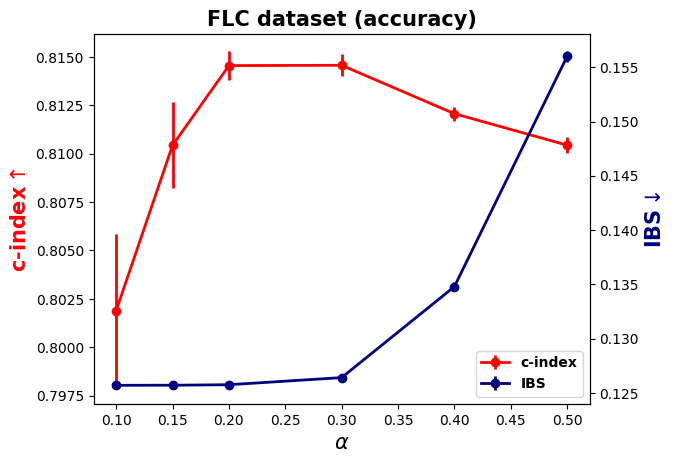

In [73]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,test_accuracy_mean[:,0], yerr=test_accuracy_std[:,0], color='red', label=r'c-index', linewidth=2, fmt='-o')
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
ax.set_ylabel(r'c-index$\uparrow$',fontsize=15, fontweight='bold', color='red')
ax2=ax.twinx()
l2 =ax2.errorbar(eps_candidates,test_accuracy_mean[:,1], yerr=test_accuracy_std[:,1], color='navy', label=r'IBS',linewidth=2, fmt='-o')
ax2.set_ylabel(r'IBS$\downarrow$',fontsize=15, fontweight='bold', color='navy')
plt.legend(handles=[l1, l2],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('FLC dataset (accuracy)', fontsize = 15, fontweight='bold')
plt.show()

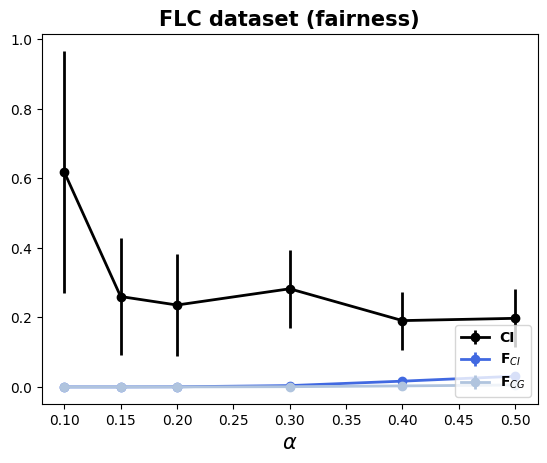

In [74]:
fig, ax = plt.subplots()
l3 =ax.errorbar(eps_candidates,test_fairness_mean[:,0], yerr=test_fairness_std[:,0], color='black', label=r'CI',linewidth=2, fmt='-o')
l4 =ax.errorbar(eps_candidates,test_fairness_mean[:,1], yerr=test_fairness_std[:,1], color='royalblue', label=r'F$_{CI}$',linewidth=2, fmt='-o')
l5 =ax.errorbar(eps_candidates,test_fairness_mean[:,2], yerr=test_fairness_std[:,2], color='lightsteelblue', label=r'F$_{CG}$',linewidth=2, fmt='-o')
# ax.errorbar(np.asarray(eps),np.asarray(C_I))
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
# ax.set_ylim((0.78, 0.81))


#plt.xticks(eps,eps)
plt.legend(handles=[l3, l4, l5],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('FLC dataset (fairness)', fontsize = 15, fontweight='bold')

plt.show()

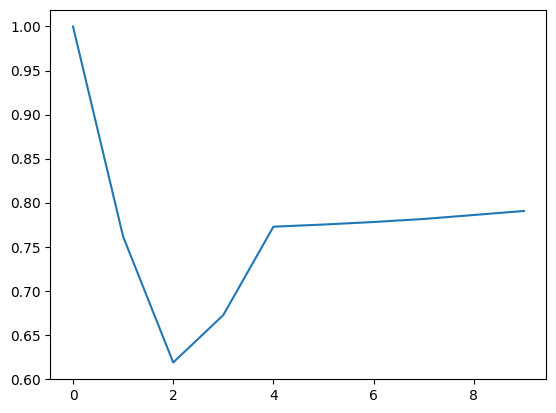

In [79]:
plt.plot(cosine_similarity(beta_fitted[0,:,:], beta_fitted[0,:,:])[0,:])

Text(0.5, 1.0, 'Euclidean norm of fitted beta')

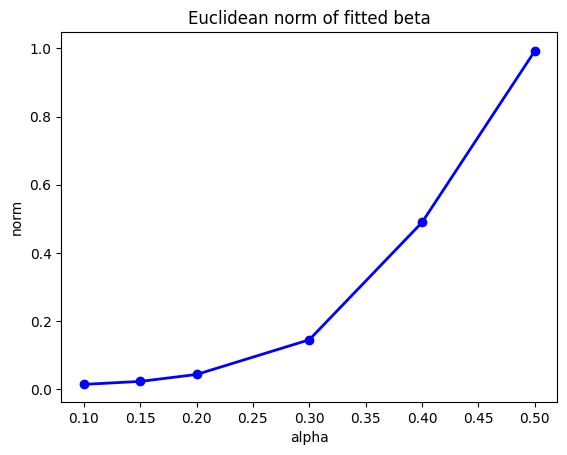

In [75]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).mean(axis=0), 
                 yerr=np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).std(axis=0), 
                 color='blue', label=r'CI',linewidth=2, fmt='-o')
plt.ylabel("norm")
plt.xlabel("alpha")
plt.title("Euclidean norm of fitted beta")

### Support (age)

In [51]:
set_random_seed(1)
data_x, data_y, protect_attr = support_preprocess()

B = 10
epochs = 500
protect_index = 0
with_scale = True
eps_candidates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
n_eps = len(eps_candidates)
beta_fitted = np.zeros((B, n_eps, data_x.shape[1]))
eta_fitted = np.zeros((B, n_eps))
test_accuracy = np.zeros((B, n_eps, 2))
test_fairness = np.zeros((B, n_eps, 3))

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"])
# data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)

scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)
data_X_test_for_distance = data_X_test / np.linalg.norm(data_X_test, axis=1, keepdims=1)
for B_ind in range(B):
    print(f"Batch {B_ind+1}:")

    # train-test split
    data_X_train_tmp, data_X_drop, data_y_train_tmp, data_y_drop, S_train_tmp, S_drop = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])
    # data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp = check_arrays_survival(data_X_train_tmp, data_y_train_tmp)
    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp = prepare_data(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp)
    
    for eps_ind, eps in enumerate(eps_candidates):
        # Train model
        model, eta_fitted[B_ind,eps_ind] = fit_dro_cox(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, eps=eps, epochs=epochs)
        
        # Store model
        beta_fitted[B_ind,eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
        print(beta_fitted[B_ind,eps_ind,:])
        
        # Evaluation on test set
        with torch.no_grad():
            train_prediction = model((torch.from_numpy(data_X_train_tmp)).float())
            train_prediction = (train_prediction.numpy()).reshape((-1,)) # beta \dot x

            test_prediction = model((torch.from_numpy(data_X_test)).float())
            test_prediction = (test_prediction.numpy()).reshape((-1,)) # beta \dot x

        # Concordance index
        # test_accuracy[i,0] = concordance_index_censored(data_event_test, data_time_test, test_prediction)[0]
        test_accuracy[B_ind,eps_ind,0] = time_dependent_C_index(data_event_train_tmp, data_time_train_tmp, data_event_test, data_time_test, test_prediction)
        
        # Integrated Brier Score
        data_event_train_tmp = data_event_train_tmp.astype(bool)
        survFunction_test = predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)

        percentiles = [100]
        tmp_IBS_from_sksurv = np.zeros(len(percentiles))
        min_time = 0
        if data_time_train_tmp.min()>data_time_test.min():
            min_time = data_time_train_tmp.min()
        else:
            min_time = data_time_test.min()
        t = 0
        times_range = np.linspace(min_time, np.percentile(data_time_test, percentiles[t]), num=50, endpoint=False)
        preds_ibs = np.asarray([[fn(i_t) for i_t in times_range] for fn in survFunction_test])
        tmp_IBS_from_sksurv[t] = integrated_brier_score(data_y_train_tmp, data_y_test, preds_ibs, times_range)
        test_accuracy[B_ind,eps_ind,1] = tmp_IBS_from_sksurv[t]
        
        # Concordance imparity
        test_fairness[B_ind,eps_ind,0] = CI(test_prediction, data_event_test, data_time_test, S_test[:, protect_index])

        pred_surv_test = np.zeros((3, len(test_prediction)))
        for i, pct in enumerate(np.percentile(data_time_test, [25, 50, 75])):
            for j, surv_func in enumerate(predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)):
                pred_surv_test[i, j] = surv_func(pct)
        
        # Individual fairness
        #test_fairness[i,eps_ind,1] = individual_fairness_scale(test_prediction, data_X_test_for_distance, 0.01)
        test_fairness[B_ind,eps_ind,1] = individual_fairness_scale_censoring_td(pred_surv_test, data_X_test_for_distance, 0.01, data_event_test, data_time_test)

        # Group fairness
        test_fairness[B_ind,eps_ind,2] = group_fairness_censoring_td(pred_surv_test, S_test[:, protect_index], data_X_test_for_distance, 0.01, data_event_test, data_time_test)
        
        print("eps = {:.2f}:".format(eps))
        print("Ctd: {:.4f}, IBS: {:.4f},".format(*test_accuracy[B_ind,eps_ind,:]), end="")
        print(" CI: {:.4f}, F_CI: {:.4f}, F_CG: {:.4f}".format(*test_fairness[B_ind,eps_ind,:]))

c:\ProgramData\anaconda3\envs\dro_surv_py3.8\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Batch 1:
[ 0.00177855 -0.0010857   0.00020404 -0.00507605  0.00276372  0.00107586
  0.00254488 -0.0028396  -0.00128107  0.00191028  0.00077769  0.00365325
  0.00105199  0.00053348]
eps = 0.10:
Ctd: 0.5826, IBS: 0.2169, CI: 2.1533, F_CI: 0.0000, F_CG: 0.0000
[ 0.00124406 -0.00098514 -0.00025117 -0.0069708   0.0041051   0.00223741
  0.00323359 -0.00412312 -0.00167505  0.00235586  0.00099306  0.00514399
  0.00141299  0.00136511]
eps = 0.15:
Ctd: 0.5853, IBS: 0.2169, CI: 2.3579, F_CI: 0.0000, F_CG: 0.0000
[ 2.06452003e-03 -1.30288862e-03 -8.20833448e-05 -8.60959198e-03
  3.66866984e-03  2.83174636e-03  2.83712242e-03 -6.76612463e-03
 -1.83373096e-03  3.10831727e-03  2.10040272e-03  6.48175785e-03
  1.68916292e-03  2.21984019e-03]
eps = 0.20:
Ctd: 0.5875, IBS: 0.2169, CI: 2.2588, F_CI: 0.0000, F_CG: 0.0000
[ 0.00316541 -0.00204134 -0.00101434 -0.01684002  0.00412852  0.00743346
  0.00256824 -0.01591457  0.00147387  0.00498962  0.00503152  0.01133446
  0.00345968  0.00416316]
eps = 0.30:
Ctd

In [52]:
test_accuracy_mean = test_accuracy.mean(axis=0)
test_accuracy_std = test_accuracy.std(axis=0)
test_fairness_mean = test_fairness.mean(axis=0)
test_fairness_std = test_fairness.std(axis=0)

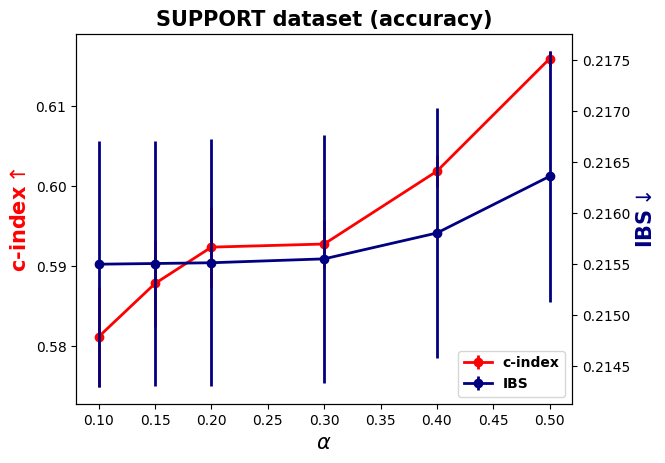

In [54]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,test_accuracy_mean[:,0], yerr=test_accuracy_std[:,0], color='red', label=r'c-index', linewidth=2, fmt='-o')
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
ax.set_ylabel(r'c-index$\uparrow$',fontsize=15, fontweight='bold', color='red')
ax2=ax.twinx()
l2 =ax2.errorbar(eps_candidates,test_accuracy_mean[:,1], yerr=test_accuracy_std[:,1], color='navy', label=r'IBS',linewidth=2, fmt='-o')
ax2.set_ylabel(r'IBS$\downarrow$',fontsize=15, fontweight='bold', color='navy')
plt.legend(handles=[l1, l2],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('SUPPORT dataset (accuracy)', fontsize = 15, fontweight='bold')
plt.show()

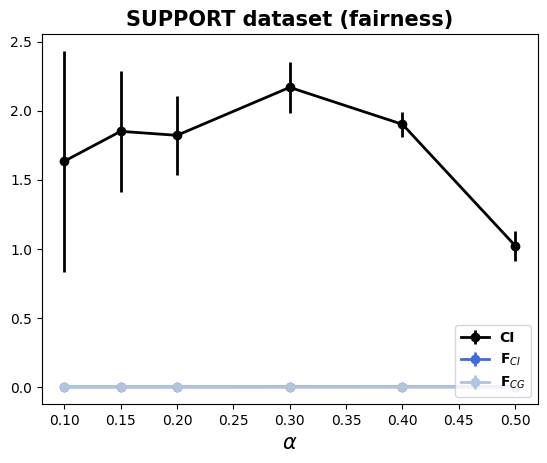

In [56]:
fig, ax = plt.subplots()
l3 =ax.errorbar(eps_candidates,test_fairness_mean[:,0], yerr=test_fairness_std[:,0], color='black', label=r'CI',linewidth=2, fmt='-o')
l4 =ax.errorbar(eps_candidates,test_fairness_mean[:,1], yerr=test_fairness_std[:,1], color='royalblue', label=r'F$_{CI}$',linewidth=2, fmt='-o')
l5 =ax.errorbar(eps_candidates,test_fairness_mean[:,2], yerr=test_fairness_std[:,2], color='lightsteelblue', label=r'F$_{CG}$',linewidth=2, fmt='-o')
# ax.errorbar(np.asarray(eps),np.asarray(C_I))
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
# ax.set_ylim((0.78, 0.81))


#plt.xticks(eps,eps)
plt.legend(handles=[l3, l4, l5],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('SUPPORT dataset (fairness)', fontsize = 15, fontweight='bold')

plt.show()

Text(0.5, 1.0, 'Euclidean norm of fitted beta (SUPPORT)')

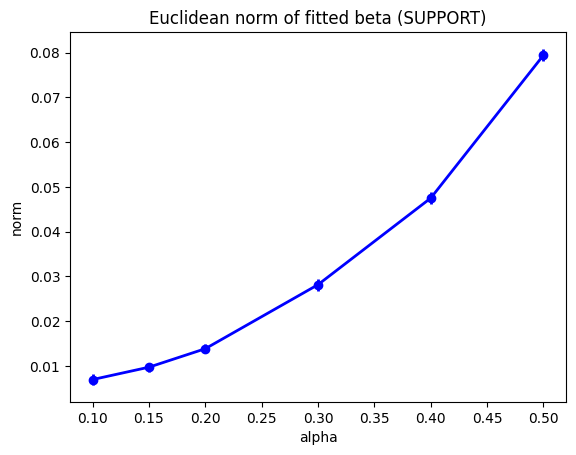

In [60]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).mean(axis=0), 
                 yerr=np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).std(axis=0), 
                 color='blue', label=r'CI',linewidth=2, fmt='-o')
plt.ylabel("norm")
plt.xlabel("alpha")
plt.title("Euclidean norm of fitted beta (SUPPORT)")

### SEER(age)

In [62]:
set_random_seed(1)
data_x, data_y, protect_attr = seer_preprocess()

B = 10
epochs = 500
protect_index = 0
with_scale = True
eps_candidates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
n_eps = len(eps_candidates)
beta_fitted = np.zeros((B, n_eps, data_x.shape[1]))
eta_fitted = np.zeros((B, n_eps))
test_accuracy = np.zeros((B, n_eps, 2))
test_fairness = np.zeros((B, n_eps, 3))

# train-test split
data_X_train, data_X_test, data_y_train, data_y_test, S_train, S_test = train_test_split(data_x, data_y, protect_attr, test_size=0.2,stratify=data_y["death"])
# data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

data_X_test, data_event_test, data_time_test = check_arrays_survival(data_X_test, data_y_test)
data_X_test, data_event_test, data_time_test, S_test = prepare_data(data_X_test, data_event_test, data_time_test, S_test)

scaler = StandardScaler()
scaler.fit(data_X_train)
data_X_train = scaler.transform(data_X_train)
data_X_test = scaler.transform(data_X_test)
data_X_test_for_distance = data_X_test / np.linalg.norm(data_X_test, axis=1, keepdims=1)
for B_ind in range(B):
    print(f"Batch {B_ind+1}:")

    # train-test split
    data_X_train_tmp, data_X_drop, data_y_train_tmp, data_y_drop, S_train_tmp, S_drop = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])
    # data_X_train, data_X_dev, data_y_train, data_y_dev, S_train, S_dev = train_test_split(data_X_train, data_y_train, S_train, test_size=0.2,stratify=data_y_train["death"])

    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp = check_arrays_survival(data_X_train_tmp, data_y_train_tmp)
    data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp = prepare_data(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, S_train_tmp)
    
    for eps_ind, eps in enumerate(eps_candidates):
        # Train model
        model, eta_fitted[B_ind,eps_ind] = fit_dro_cox(data_X_train_tmp, data_event_train_tmp, data_time_train_tmp, eps=eps, epochs=epochs)
        
        # Store model
        beta_fitted[B_ind,eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
        print(beta_fitted[B_ind,eps_ind,:])
        
        # Evaluation on test set
        with torch.no_grad():
            train_prediction = model((torch.from_numpy(data_X_train_tmp)).float())
            train_prediction = (train_prediction.numpy()).reshape((-1,)) # beta \dot x

            test_prediction = model((torch.from_numpy(data_X_test)).float())
            test_prediction = (test_prediction.numpy()).reshape((-1,)) # beta \dot x

        # Concordance index
        # test_accuracy[i,0] = concordance_index_censored(data_event_test, data_time_test, test_prediction)[0]
        test_accuracy[B_ind,eps_ind,0] = time_dependent_C_index(data_event_train_tmp, data_time_train_tmp, data_event_test, data_time_test, test_prediction)
        
        # Integrated Brier Score
        data_event_train_tmp = data_event_train_tmp.astype(bool)
        survFunction_test = predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)

        percentiles = [100]
        tmp_IBS_from_sksurv = np.zeros(len(percentiles))
        min_time = 0
        if data_time_train_tmp.min()>data_time_test.min():
            min_time = data_time_train_tmp.min()
        else:
            min_time = data_time_test.min()
        t = 0
        times_range = np.linspace(min_time, np.percentile(data_time_test, percentiles[t]), num=50, endpoint=False)
        preds_ibs = np.asarray([[fn(i_t) for i_t in times_range] for fn in survFunction_test])
        tmp_IBS_from_sksurv[t] = integrated_brier_score(data_y_train_tmp, data_y_test, preds_ibs, times_range)
        test_accuracy[B_ind,eps_ind,1] = tmp_IBS_from_sksurv[t]
        
        # Concordance imparity
        test_fairness[B_ind,eps_ind,0] = CI(test_prediction, data_event_test, data_time_test, S_test[:, protect_index])

        pred_surv_test = np.zeros((3, len(test_prediction)))
        for i, pct in enumerate(np.percentile(data_time_test, [25, 50, 75])):
            for j, surv_func in enumerate(predict_survival_function(train_prediction, data_event_train_tmp, data_time_train_tmp, test_prediction)):
                pred_surv_test[i, j] = surv_func(pct)
        
        # Individual fairness
        #test_fairness[i,eps_ind,1] = individual_fairness_scale(test_prediction, data_X_test_for_distance, 0.01)
        test_fairness[B_ind,eps_ind,1] = individual_fairness_scale_censoring_td(pred_surv_test, data_X_test_for_distance, 0.01, data_event_test, data_time_test)

        # Group fairness
        test_fairness[B_ind,eps_ind,2] = group_fairness_censoring_td(pred_surv_test, S_test[:, protect_index], data_X_test_for_distance, 0.01, data_event_test, data_time_test)
        
        print("eps = {:.2f}:".format(eps))
        print("Ctd: {:.4f}, IBS: {:.4f},".format(*test_accuracy[B_ind,eps_ind,:]), end="")
        print(" CI: {:.4f}, F_CI: {:.4f}, F_CG: {:.4f}".format(*test_fairness[B_ind,eps_ind,:]))

c:\ProgramData\anaconda3\envs\dro_surv_py3.8\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Batch 1:
[ 0.00677562  0.00658075  0.00479345  0.00668589  0.01216718 -0.00361658
 -0.01409395  0.00201062 -0.00324748  0.00382513  0.00244667 -0.00126968
 -0.0048985 ]
eps = 0.10:
Ctd: 0.6076, IBS: 0.0886, CI: 6.5341, F_CI: 0.0000, F_CG: 0.0000
[ 9.45839286e-03  2.95935874e-03  7.62481987e-03  1.50029408e-02
  1.30821513e-02 -3.04300501e-03 -1.22089908e-02  1.97061291e-03
 -8.02183058e-03  6.30176440e-03  4.63818759e-03 -4.86438815e-03
  1.57150225e-05]
eps = 0.15:
Ctd: 0.6665, IBS: 0.0886, CI: 3.6633, F_CI: 0.0000, F_CG: 0.0000
[ 0.01356302 -0.0002728   0.01233788  0.02104576  0.0107402   0.00293936
 -0.01219121 -0.00063982 -0.01058046  0.0096096   0.01459362 -0.00978461
  0.00868349]
eps = 0.20:
Ctd: 0.6992, IBS: 0.0886, CI: 2.8594, F_CI: 0.0000, F_CG: 0.0000
[ 0.0643283  -0.0073574   0.03562583  0.07293512  0.06943563  0.04064371
 -0.03414868 -0.00582218 -0.02129804  0.04615231  0.08616291 -0.07759093
  0.05832892]
eps = 0.30:
Ctd: 0.7087, IBS: 0.0893, CI: 2.0126, F_CI: 0.0047, F_C

In [64]:
data_x.shape

(4024, 13)

In [65]:
test_accuracy_mean = test_accuracy.mean(axis=0)
test_accuracy_std = test_accuracy.std(axis=0)
test_fairness_mean = test_fairness.mean(axis=0)
test_fairness_std = test_fairness.std(axis=0)

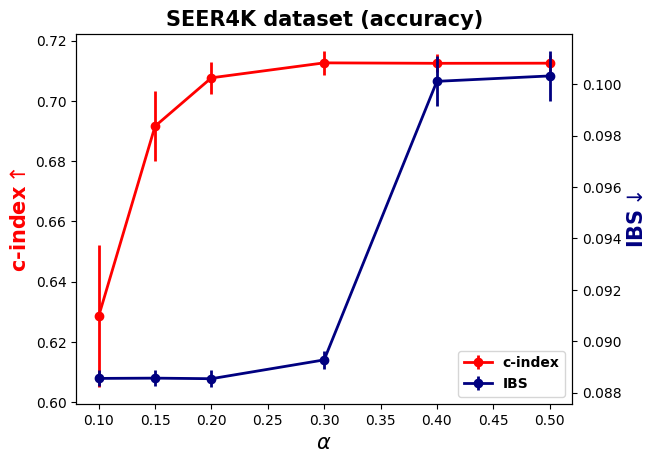

In [69]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,test_accuracy_mean[:,0], yerr=test_accuracy_std[:,0], color='red', label=r'c-index', linewidth=2, fmt='-o')
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
ax.set_ylabel(r'c-index$\uparrow$',fontsize=15, fontweight='bold', color='red')
ax2=ax.twinx()
l2 =ax2.errorbar(eps_candidates,test_accuracy_mean[:,1], yerr=test_accuracy_std[:,1], color='navy', label=r'IBS',linewidth=2, fmt='-o')
ax2.set_ylabel(r'IBS$\downarrow$',fontsize=15, fontweight='bold', color='navy')
plt.legend(handles=[l1, l2],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('SEER4K dataset (accuracy)', fontsize = 15, fontweight='bold')
plt.show()

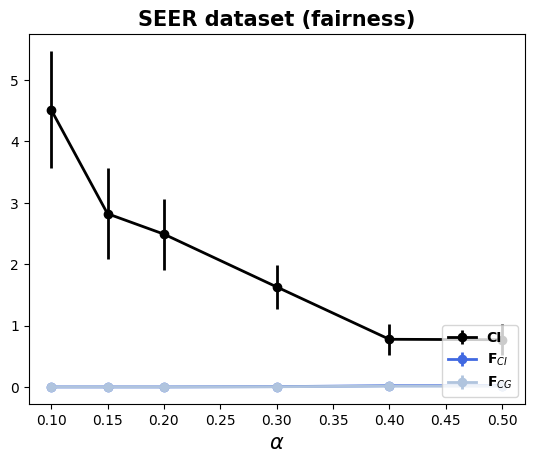

In [ ]:
fig, ax = plt.subplots()
l3 =ax.errorbar(eps_candidates,test_fairness_mean[:,0], yerr=test_fairness_std[:,0], color='black', label=r'CI',linewidth=2, fmt='-o')
l4 =ax.errorbar(eps_candidates,test_fairness_mean[:,1], yerr=test_fairness_std[:,1], color='royalblue', label=r'F$_{CI}$',linewidth=2, fmt='-o')
l5 =ax.errorbar(eps_candidates,test_fairness_mean[:,2], yerr=test_fairness_std[:,2], color='lightsteelblue', label=r'F$_{CG}$',linewidth=2, fmt='-o')
# ax.errorbar(np.asarray(eps),np.asarray(C_I))
ax.set_xlabel(r"$\alpha$", fontsize = 15, fontweight='bold')
# ax.set_ylim((0.78, 0.81))


#plt.xticks(eps,eps)
plt.legend(handles=[l3, l4, l5],prop={'size': 10, 'weight':'bold'}, loc='lower right')
plt.title('SEER4K dataset (fairness)', fontsize = 15, fontweight='bold')

plt.show()

Text(0.5, 1.0, 'Euclidean norm of fitted beta (SEER4K)')

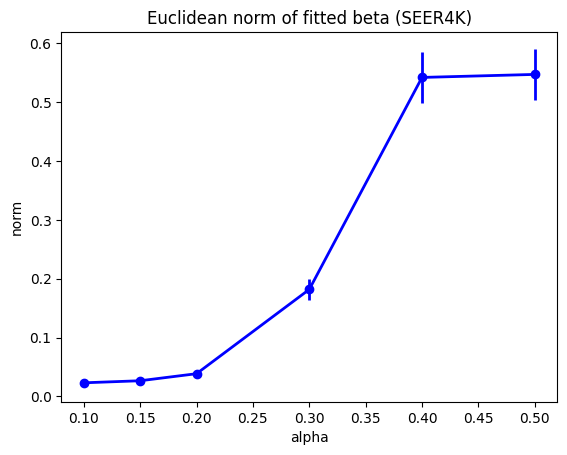

In [70]:
fig, ax = plt.subplots()
l1 = ax.errorbar(eps_candidates,np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).mean(axis=0), 
                 yerr=np.sqrt((beta_fitted*beta_fitted).sum(axis=2)).std(axis=0), 
                 color='blue', label=r'CI',linewidth=2, fmt='-o')
plt.ylabel("norm")
plt.xlabel("alpha")
plt.title("Euclidean norm of fitted beta (SEER4K)")